# Spectroscopy Processing (Part 2)
This is divided into two parts
1. Some background and an informal analysis of the signal characteristics measured in an MRS experiment
2. Processing the measured signal to produce spectra for the purpose of quantifying relative contributions from fat/water.

## Setup
These sections are copied/repeated from Part 1, which contains a more detailed explanation of them.

In [8]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML
%matplotlib inline

def plot_with_titles(x, y, maintitle="", xlabel="", ylabel="", xlim=None, ylim=None, **kwargs):
    p = plt.plot(x, y, **kwargs)
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if maintitle is not None:
        plt.title(maintitle)
        
def fid_resonance(t, amp, alpha, beta, f, phi0):
    '''
    Simulate a FID with gaussian/exponential lineshape:
     t : time(s)
     amp: amplitude area under the spectrum of this resonance
     alpha: exponential envelope contribution
     beta: gaussian envelope contribution
     f: frequency of resonance (Hz)
     phi0: initial phase of resonance
    '''

    envelope = amp * np.exp(-alpha*t) * np.exp(-(beta*t)**2)
    signal = envelope * np.exp(1j * (2*np.pi*f*t + phi0))
    
    signal[0] = signal[0] / 2.025 # first point correction
    # add some phase
    #signal = np.roll(signal, -1)
    
    return signal

### Constants

In [9]:
gamma_bar = 42.58 # Mhz/T (of 1H)
field_str = 3.0   # T
acq_bw = 2000.0   # 1.0/sec -> samples per second.
num_pts = 2048    # number of points to acquire
acq_te = 54.0     # ms

# Simulation parameters
alpha = 60.0      # exponential contribution
beta = 40.0       # gaussian contribution

# The resonances of the fat spectrum (used in Dixon model)
ppm_templ  = np.array([ 5.3, 4.13, 2.78, 2.24, 2.03, 1.57, 1.3, 0.9 ]) - 4.7
freq_templ = ppm_templ * gamma_bar * field_str # convert to frequency @ field_str
freq_templ = np.insert(freq_templ, 0, 0) # insert water at center frequency (0)

fat_fraction = 0.60
water_amp = (1.0 - fat_fraction)/fat_fraction

# each resonance may have its own inherent T2
t2s_templ  = [ 30.0, 38.7, 25.4, 41.5, 41.9, 41.9, 41.9, 46.0, 71.4 ]

# but for this example, just fix them to all having the same T2
#t2s_templ  = np.repeat(30.0, len(t2s_templ))

amps_templ = [ water_amp, 0.065934, 0.034965, 0.010989, 0.051948, 0.076923, 0.046953, 0.597403, 0.114885 ]

# apply the T2 weighting to the amplitudes
amps_weighted = np.array(amps_templ) * np.exp(-acq_te/np.array(t2s_templ))

# Normalize so that total(amps_weighted) = 1.0
amps_weighted = amps_weighted/amps_weighted.sum()

In [10]:
t = np.arange(num_pts, dtype=np.float)/acq_bw # total time = [(# of samples) * (time for one sample)]
f_k = np.ndarray(shape=(num_pts, len(freq_templ)), dtype=np.complex)

for i, amp in enumerate(amps_weighted):
    f_k[:,i] = fid_resonance(t, amps_weighted[i], alpha, beta, freq_templ[i], 0.0)

f_total = f_k.sum(axis=1)

df = pd.read_csv('./Simulated_FID_Example_invivo_data.csv')
y = (df.re_fid + 1j * df.im_fid) * np.exp(1j * np.pi * 1.99)

## Processing and Analysis
Part 1 provided a basic introduction to what is acquired by the MRI system during an SVS STEAM experiment, but we have yet to encounter a spectrum similar to what is found in analysis reports. That is because quantitative analysis of these FID measurements requires a bit more processing to be useful.

There are two questions relevant to iDMD that the SVS STEAM measurements can answer:

1. What's T2 of muscle water within thie voxel.
    - To answer this, a means to pull out the specific contribution of water is needed.
2. What's the fat fraction within this voxel.
    - To answer this, a means of quantifying the contribution of water and fat separately is needed.

Both of those questions involving quantifying the contribution of specific components (frequencies), but this is very difficult to do with a time-dependent signal. 

The **Discrete Fourier Transform**,

$$
X_{k} = \sum _{n=0}^{N-1}x_{n}\cdot e^{-i2\pi kn/N},
$$

is used to convert the time-dependent signal ($x_n$) into a frequency-depenedent spectrum. The x-axis in a frequency spectrum is Hz (i.e. 1/sec), and the y-axis represents the relative contriubtion to the overall signal from a frequency.

One thing to note about this process is that the value at some single frequency, $X_{k}$, is calculated from _all_ points in the time-domain signal. Below, the DFT is calculated for the simulated $\mathrm{CH_2}$ resonance:

In [11]:
from time import time
x_hz = (np.arange(num_pts) - num_pts/2.0)/num_pts * acq_bw
ft_k = f_k[:,6] * 0.0
calc_start = time()
for k in range(num_pts):
    for n in range(num_pts):
        ft_k[k] = ft_k[k] + f_k[n,6] * np.exp(-2j*np.pi*k*(1.0*n)/num_pts)
print("Calculation of DFT using double-loop method at each frequency took %0.1f seconds." % (time() - calc_start))

Calculation of DFT using double-loop method at each frequency took 5.4 seconds.


In practice, though, the formal DFT formula is rarely used since it is relatively slow, with the calculation time increasing _quadratically_ as the number of points increases. Instead the Fast Fourier Transform is most often used. Below the result from the formal DFT and python's `numpy` built-in `fft` function are plotted and compared:

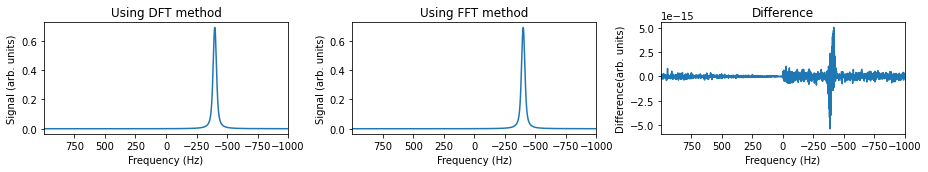

In [12]:
f = plt.figure(figsize=(13,2.5))
plt.subplot(1,3,1)
plot_with_titles(x_hz, fft.fftshift(np.real(ft_k)), 
                 xlabel="Frequency (Hz)", ylabel="Signal (arb. units)", maintitle="Using DFT method",
                 xlim=(x_hz.max(),x_hz.min()))
plt.subplot(1,3,2)
plot_with_titles(x_hz, fft.fftshift(np.real(fft.fft(f_k[:,6]))), 
                 xlabel="Frequency (Hz)", ylabel="Signal (arb. units)", maintitle="Using FFT method",
                 xlim=(x_hz.max(),x_hz.min()))
plt.subplot(1,3,3)
plot_with_titles(x_hz, fft.fftshift(np.real(fft.fft(f_k[:,6]))) - fft.fftshift(np.real(ft_k)), 
                 xlabel="Frequency (Hz)", ylabel="Difference(arb. units)", maintitle="Difference",
                 xlim=(x_hz.max(),x_hz.min()))
f.tight_layout()

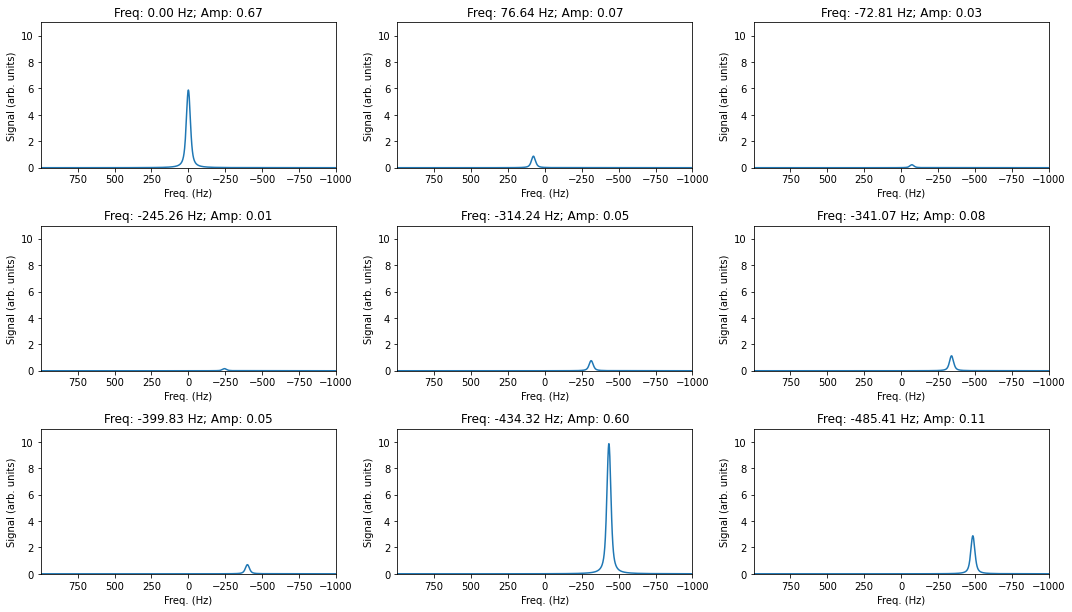

In [13]:
f = plt.figure(figsize=(15,11))
# generate a x-axis in frequency domain
x_hz = (np.arange(num_pts) - num_pts/2.0)/num_pts * acq_bw
for i in range(len(freq_templ)):
    plt.subplot(4,3,i+1)
    fid = fft.fftshift(fft.fft(f_k[:,i]))
    plot_with_titles(x_hz, np.real(fid), xlim=(x_hz.max(),x_hz.min()), ylim=(0,11.0), 
                     xlabel="Freq. (Hz)", ylabel="Signal (arb. units)", 
                     maintitle='Freq: %0.2f Hz; Amp: %0.2f' % (freq_templ[i], amps_templ[i]))
f.tight_layout()

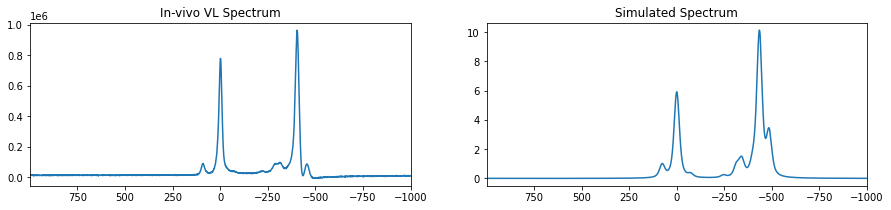

In [14]:
f = plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
actual_data = df['re_fid'] + 1j * df['im_fid']
plot_with_titles(x_hz, np.real(fft.fftshift(fft.fft(actual_data))), xlim=(x_hz.max(), x_hz.min()), 
                maintitle="In-vivo VL Spectrum")
simulated_data = f_k.sum(axis=1)
plt.subplot(1,2,2)
plot_with_titles(x_hz, np.real(fft.fftshift(fft.fft(simulated_data))), xlim=(x_hz.max(), x_hz.min()),
                maintitle="Simulated Spectrum")

## Answering the Questions
Now there is enough background to try to answer some of the questions posed earlier.

1. What's T2 of muscle water within thie voxel.
2. What's the fat fraction within this voxel.

Before starting to answer either of those, there is one issue to be noted:  

All of the plots so far suggest a continuous axis. In reality measured/simulated data consists of discretely-sampled points on that axis. This means that the exact values for some frequency/ppm values within our sampled range will be unavailable. For example, there is no measured value in our data at -7.4 Hz. The closest measured value to -7.4 Hz can be found pretty easily, by finding the value in the `x_hz` array that has the closest value to -7.4.

Closest x to -7.4 = -7.812 (4.12e-01 away) at array index 1016


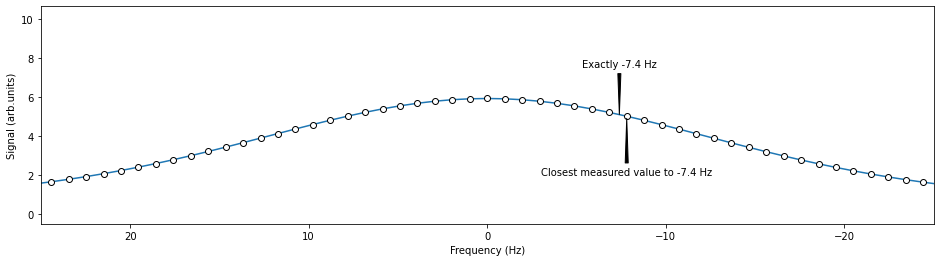

In [15]:
# find the closest point - this will be needed later in the quantative part.
def find_closest_pt_to_x(x_axis, x_wanted):
    """Returns tuple with following info:
       (closest measured point on x-axis,
       distance from wanter to measured point,
       array index of closest point)"""
    x_closest = (None, 1e12, 0) # x_closest[2] hold the closest distance found, initialized to be really big.
    for i, x in enumerate(x_axis):
        x_distance = np.abs(x - x_wanted)
        if x_distance < x_closest[1]:
            x_closest = (x, x_distance, i)
    print("Closest x to " + str(x_wanted) + " = %0.3f (%0.2e away) at array index %d" % x_closest)
    return x_closest

real_sim_spect = np.real(fft.fftshift(fft.fft(simulated_data)))
x_closest = find_closest_pt_to_x(x_hz, -7.4)

f = plt.figure(figsize=(16,4))
plot_with_titles(x_hz, real_sim_spect,
                 xlim=(25, -25), xlabel='Frequency (Hz)', ylabel='Signal (arb.units)')
plt.plot(x_hz, real_sim_spect, 'o', color='black', mfc='white')
_ = plt.annotate('Closest measured value to -7.4 Hz', xy=(x_closest[0], 5), xytext=(-7.812, 2.0),
                 arrowprops=dict(facecolor='black', arrowstyle='wedge'),
                 horizontalalignment='center')
_ = plt.annotate('Exactly -7.4 Hz', xy=(-7.4, 5), xytext=(-7.4, 7.5),
                 arrowprops=dict(facecolor='black', arrowstyle='wedge'),
                 horizontalalignment='center')

**Just as a side note**: if knowing the exact spectrum value at -7.4 Hz was really important, so much so that the closest measured point was just not good enough, then the exact value can be estimated.

Even though the spectrum looks pretty curvy from a distance, between two sampled points it looks basically like a straight line: $y = mx + b$, where $m = (y^+ - y^-)/(x^+ - x^-)$ and $b = y^+ - mx^+$. It is possible to estimate the exact spectrum value at -7.4 Hz by linear interpolation between the neighbor points.

Interpolated measurement at -7.4 Hz = 5.091


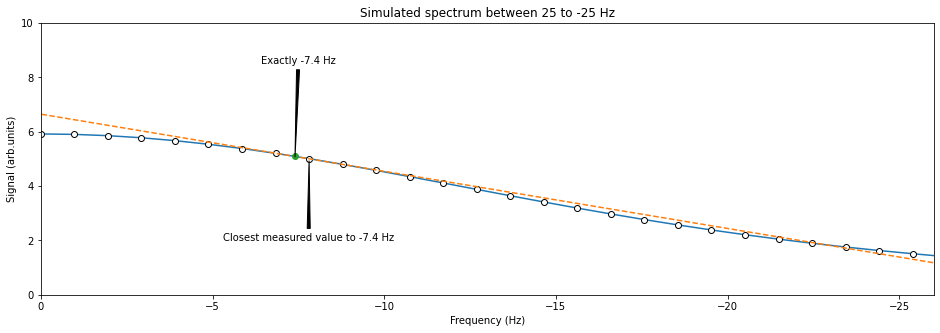

In [16]:
x_plus = x_closest[2]-1
x_minus = x_closest[2]
y_plus = real_sim_spect[x_plus]
y_minus = real_sim_spect[x_minus]
m = (y_plus - y_minus)/(x_plus - x_minus)
b = real_sim_spect[x_plus] - m * x_hz[x_plus]
y_interpolated = m*(-7.4) + b
print("Interpolated measurement at -7.4 Hz = %0.3f" % (y_interpolated))

f = plt.figure(figsize=(16,5))
plot_with_titles(x_hz, real_sim_spect,
                 xlim=(0, -26), xlabel='Frequency (Hz)', ylabel='Signal (arb.units)',
                 ylim=(0, 10), maintitle='Simulated spectrum between 25 to -25 Hz')
plt.plot(x_hz, real_sim_spect, 'o', color='black', mfc='white')
plt.plot(x_hz, m*x_hz + b, '--')
plt.plot([-7.4], [y_interpolated], 'o')
_ = plt.annotate('Closest measured value to -7.4 Hz', xy=(x_closest[0], 5), xytext=(-7.8, 2.0),
                 arrowprops=dict(facecolor='black', arrowstyle='wedge'),
                 horizontalalignment='center')
_ = plt.annotate('Exactly -7.4 Hz', xy=(-7.4, 5), xytext=(-7.5, 8.5),
                 arrowprops=dict(facecolor='black', arrowstyle='wedge'),
                 horizontalalignment='center')

### 1. What's T2 of muscle water within thie voxel.
Outline of steps:
1. Simulate some spectra measured at different TEs. The T2 values prescribed above in []() will govern the signal decay.
2. Define the bounds to the left and right of the peak of interest.
3. Extract the spectral values within those bounds
4. Calculate the total amplitude and curve-fit that amplitude to the T2 decay equation to recover the T2.

#### Simulate some spectra

In [22]:
t = np.arange(num_pts, dtype=np.float)/acq_bw # total time = [(# of samples) * (time for one sample)]
echo_times = [ 11.0, 27.0, 54.0, 243.0 ]

# make an array to hold the fid for each resonance to keep them separate.
f_te = np.ndarray(shape=(num_pts, len(echo_times)), dtype=np.complex) * (0.0 + 0.0j)

for i, te in enumerate(echo_times):
    # apply T2 weighting
    amp_weighted = amps_templ * np.exp(-te/np.array(t2s_templ))
    for j, amp in enumerate(amp_weighted):
        # make the FIDs and add them up
        f_te[:,i] = f_te[:,i] + fid_resonance(t, amp, alpha, beta, freq_templ[j], 0.0)

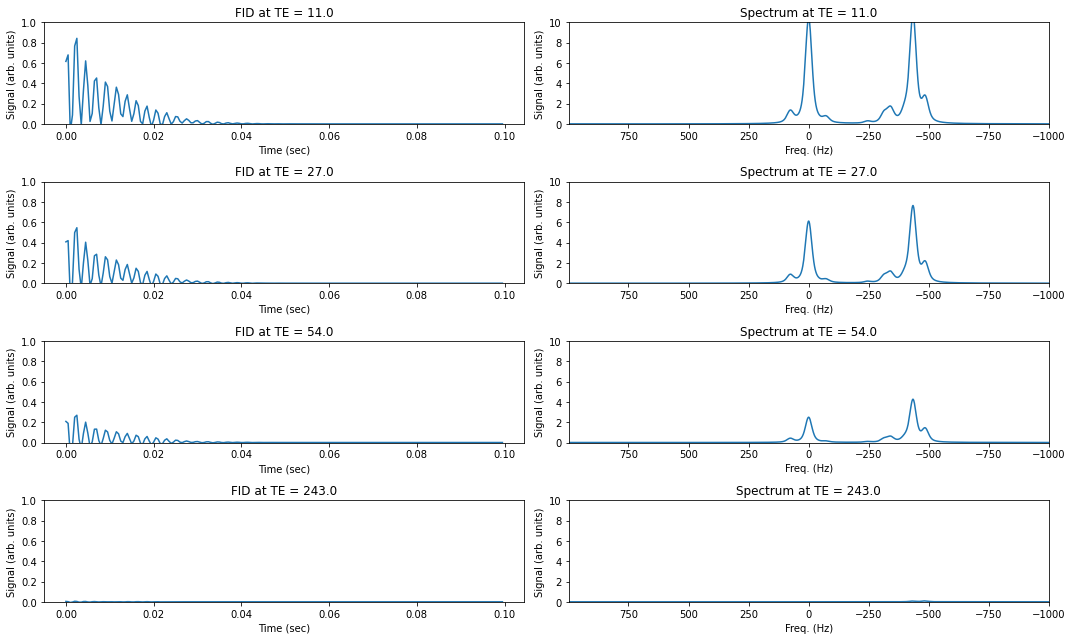

In [27]:
f = plt.figure(figsize=(15,9))
# generate a x-axis in frequency domain
x_hz = (np.arange(num_pts) - num_pts/2.0)/num_pts * acq_bw
plt_ctr = 1
for i in range(len(echo_times)):
    plt.subplot(4,2,plt_ctr)
    plot_with_titles(t[0:200], np.real(f_te[0:200,i]), 
                     xlabel="Time (sec)", ylabel="Signal (arb. units)", maintitle="FID at TE = %0.1f" % echo_times[i], ylim=(0, 1))
    plt_ctr = plt_ctr + 1
    plt.subplot(4,2,plt_ctr)
    fid = fft.fftshift(fft.fft(f_te[:,i]))
    plot_with_titles(x_hz, np.real(fid), xlim=(x_hz.max(),x_hz.min()), 
                     xlabel="Freq. (Hz)", ylabel="Signal (arb. units)", maintitle="Spectrum at TE = %0.1f" % echo_times[i], ylim=(0, 10))
    plt_ctr = plt_ctr + 1
f.tight_layout()

#### Define the bounds

As the purpose takes on more of a quantitative role, switching to ppm axis is better, since remember this is independent of field strength.

Before starting to answer either of those, there is one issue to be resolved: the various x-axes. Recall in the [Resonance Characterists](#Resonance-characteristics) section that the spectrum was expressed in two x-axes: **Frequency (Hz)** and **ppm**. Now that the work has turned toward quantification, its better to work using the ppm axis, so that our methods are not spcieif to any particular field-strength.

The formula for moving between from Hz to ppm,

$$
X_{\mathrm{hz}} = X_{\mathrm{ppm}} \cdot \bar{\gamma} \cdot T,
$$


In [28]:
x_ppm = (4.7 + x_hz/42.58/3.0)

Define the water peak as the spectrum between 5.1 and 4.3 ppm (centered on 4.7), and get the closest measured points to those pre-definted bounds.

Closest x to 4.3 = 4.302 (2.46e-03 away) at array index 972
Closest x to 5.1 = 5.098 (2.46e-03 away) at array index 1076


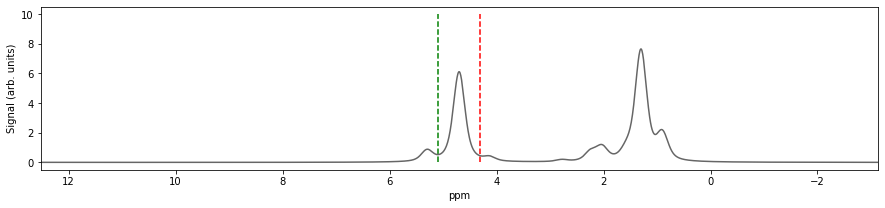

In [29]:
f = plt.figure(figsize=(15,3))
bound_a = find_closest_pt_to_x(x_ppm, 4.3) #np.where(abs(x_ppm - 4.3) == np.min(abs(x_ppm - 4.3)))
bound_b = find_closest_pt_to_x(x_ppm, 5.1) #np.where(abs(x_ppm - 5.1) == np.min(abs(x_ppm - 5.1)))
plt.plot([bound_a[0], bound_a[0]], [0, 10], ls='--', color='red')
plt.plot([bound_b[0], bound_b[0]], [0, 10], ls='--', color='green')
plot_with_titles(x_ppm, np.real(fft.fftshift(fft.fft(f_te[:,1]))), xlim=(x_ppm.max(),x_ppm.min()), 
                 xlabel="ppm", ylabel="Signal (arb. units)", color='#666666')

#### Extract the data within bounds
Now that the array indices of the closest measured points are available, use numpy's array slicing syntax to sum up the spectral values between those bounds, calculating the water amplitude at each TE:

Water amplitude for TE = 11.00 between (972 and 1076) = 641.183
Water amplitude for TE = 27.00 between (972 and 1076) = 375.539
Water amplitude for TE = 54.00 between (972 and 1076) = 152.153
Water amplitude for TE = 243.00 between (972 and 1076) = 0.465


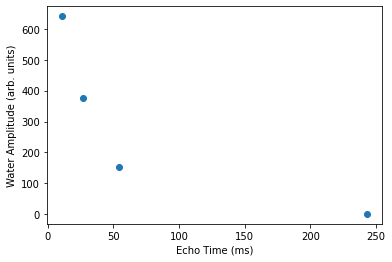

In [30]:
bounds = [np.min([bound_a[2], bound_b[2]]), np.max([bound_a[2], bound_b[2]])]
s_te = np.repeat(0.0, len(echo_times))
for j in range(len(echo_times)):
    spectrum_te = fft.fftshift(fft.fft(f_te[:,j]))
    s_te[j] = np.abs(spectrum_te)[ bounds[0] : bounds[1] ].sum()
    print("Water amplitude for TE = %0.2f between (%d and %d) = %0.3f" % (
        echo_times[j], bounds[0], bounds[1], s_te[j]
    ))

_ = plt.plot(echo_times, s_te, 'o')
_ = plt.xlabel("Echo Time (ms)")
_ = plt.ylabel("Water Amplitude (arb. units)")

#### Curve fit
The `curve_fit` function from `scipy.optimize` is pretty easy to use and will perform a non-linear least squared fit. The details of curve fitting can be found elsewhere.

The accepted model of $T_2$ decay is
$$
S(\mathrm{te}) = S_0 \cdot \exp\left(\frac{-\mathrm{te}}{T_2}\right) + c,
$$
although the $c$ term may be omitted if the measured data do not support estimating this value. For example, the iDMD imaging-based $T_2$ fitting does not estimate $c$.

In [31]:
from scipy.optimize import curve_fit
def fit_function (te, s0, t2, c):
    """Exponential T2 decay function with constant baseline offset:
      S0 ~ Estimated signal value at TE = 0 (fit)
      T2 ~ Estimated T2 in same units as TE values
      c  ~ Estimated baseline (signal at TE = infinity)
      te ~ TE (provided/prescribed)"""
    
    return s0 * np.exp(-te/t2) + c

popt, pconv = curve_fit(fit_function, echo_times, np.real(s_te))
print("Estimated S0: %0.3f" % popt[0])
print("Estimated T2: %0.3f ms (actual: %0.2f ms)" % (popt[1], t2s_templ[0]))
print("Estimated  c: %0.3f" % popt[2])

Estimated S0: 926.277
Estimated T2: 29.885 ms (actual: 30.00 ms)
Estimated  c: 0.170


Now the estimation curve can be displayed, showing the estimated water amplitude at any TE desired...

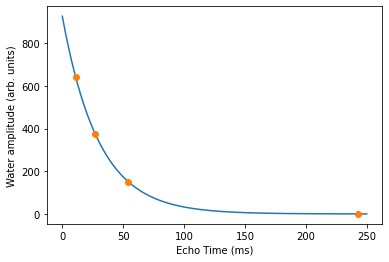

In [32]:
lots_of_tes = np.arange(200, dtype=np.float)/(200-1) * 250.
est_curve = fit_function(lots_of_tes, popt[0], popt[1], popt[2])
plt.plot(lots_of_tes, est_curve)
plt.plot(echo_times, abs(s_te), 'o')
plt.xlabel("Echo Time (ms)")
_ = plt.ylabel("Water amplitude (arb. units)")

### 2. What's the corrected fat fraction within this voxel.
Outline of steps:
1. Simulate a spectrum measured some single TEs. The T2 values prescribed above in []() will govern the signal decay.
2. Define the bounds to the left and right of the water peak and fat peak separatly.
3. Extract the spectral values within those bounds for water and for fat
4. Calculate the total amplitude of water $(w)$ and fat $(f)$
5. Correct water $(w_c)$ and fat $(f_c)$ for T2 relaxation differences.    
6. Calculate the fat fraction using: $ff_c = f_c/\left(f_c+w_c\right)$.

In [ ]:
## To be continued...